### TechMasters Data Science Project
### Hazırlayan: Yalçın Yüksel

# Walmart Haftalık Satış

### Veri Seti ve Parametreler

**[Walmart Haftalık Satış Veri Seti](https://www.kaggle.com/datasets/yasserh/walmart-dataset)**

- **Store** - Mağaza Numarası
- **Date** - Satış Haftası
- **Weekly_Sales** - Haftalık Satışlar
- **Holiday_Flag** - Tatil Haftası, (_1 ise tatil haftası, 0 ise tatil haftası değil_)
- **Temperature** - Satış Haftası Sıcaklık
- **Fuel_Price** - Bölgedeki Yakıt Maliyeti
- **CPI** – Geçerli Tüketici Fiyat Endeksi
- **Unemployment** - Mevcut İşsizlik Oranı

### Proje Amacı
Bu proje kapsamında Walmart'ın 2010-2012 yılları arasında belirli mağazalardaki haftalık satış rakamlarını tahmin etmek için algoritmalar oluşturulmuştur. Daha sonra bu algoritmaların karşılaştırılması yapılmıştır.  

## **1. Adım:** Kütüphanelerin Yüklenmesi 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from mlxtend.preprocessing import minmax_scaling
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree

## **2. Adım:** Veri Setinin yüklenmesi ve incelenmesi

Veri setinin yüklendikten sonra içinde bulunan verilen incelenmiş ve eksik verilerin olup olmadığı kontrol edilmiştir

In [2]:
# Veri Seti Yükleme

df=pd.read_csv("walmart-sales-dataset-of-45stores.csv")
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [3]:
# Veri Seti hakkında bilgi ve eksik verilerin kontrolü

print('{}\n--------------------------------------- \n\nEKSİK VERİLER\n\n{}'
      .format(df.info(), df.isnull().sum().sort_values(ascending = False)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB
None
--------------------------------------- 

EKSİK VERİLER

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64


## **3. Adım: Karşılıklı Bilgi (Mutual Information):**
Veri setinde bulunan sütunların haftalık satış üzerindeki etkisini incelemek için "Karşılıklı Bilgi"den faydalanılmıştır. Karşılıklı bilgi, iki nicelik arasındaki ilişkiyi ölçmesi bakımından korelasyona çok benzer. Karşılıklı bilginin avantajı, her türlü ilişkiyi algılayabilmesi, korelasyon ise yalnızca doğrusal ilişkileri algılayabilmektedir.

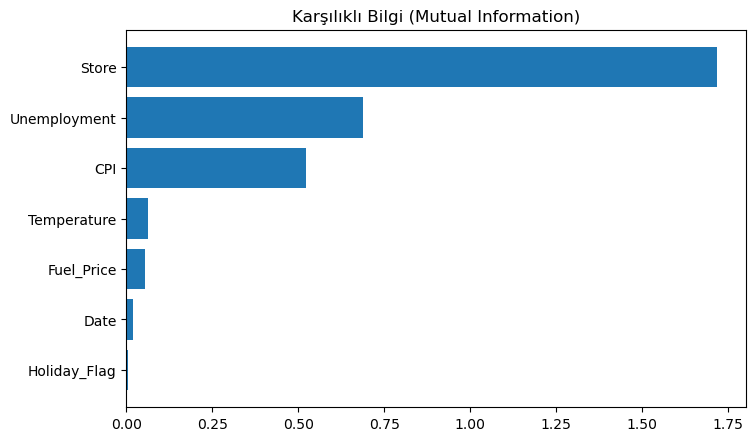

In [4]:
# Karşılıklı Bilgi

X = df.copy()
y = X.pop("Weekly_Sales")
discrete_features = X.dtypes == int
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()



def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Karşılıklı Bilgi (Mutual Information)")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

- Karşılıklı Bilgi incelendiğinde tek başına _'Date'_ ve _'Holiday_Flag'_ değişkenlerinin haftalık satış üzerinde, diğerlerine oranla çok düşük bir etkisi olduğu görülmektedir. Fakat Mağaza satışları görselleştirildiğinde, bu iki değişkenin birlikte incelendi zaman yılbaşına gelen dönemde satış rakamlarında ciddi artış olduğu görülmektedir. 

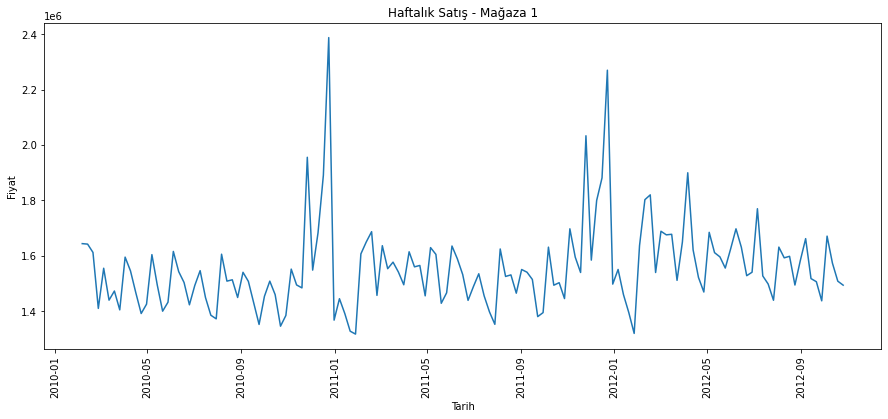

In [5]:
# Mağaza 1 Haftalık Satış Grafiği

df.index=df['Store']
df["Date"] = pd.to_datetime(df.Date,format="%d-%m-%Y")
data = df.loc["1"]

plt.figure(figsize=(15,6))

plt.plot(data.Date,data.Weekly_Sales)


plt.xticks(rotation=90)

plt.title("Haftalık Satış - Mağaza 1")
plt.xlabel("Tarih")
plt.ylabel("Fiyat")

plt.show()

## **4. Adım: Eğitim ve Test Verileri**
Haftalık Satış Tahmini için kullanılacak parametreler belirlendikten sonra eğitim ve test verileri oluşturuldu. Oluşturulan vefriler algoritma karşılaştırmasından sonra en iyi algoritma ile tahmin için kullanılacak. 

In [6]:
# Parametreler ve Eğitim Test Verileri

cols_to_use = ['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
X = df[cols_to_use]
y = df.Weekly_Sales
X_scaling = minmax_scaling(X, columns = cols_to_use)
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, 
                                                                random_state=1, shuffle=True)

## **5. Adım: Algoritmalar**
Haftalık Satış tahmini için 6 adet model seçilmiştir. Bunlar;
- Bayesian Regression
- Polynomial Regresion
- Decision Tree Regression
- Random Forest Regression
- Grandien Boosting Regression
- XGBoosting Regression

Modeller oluşturulduktan sonra cross_val_score yardımıyla bütün modellerin "R score" değerleri bulunmuş ve karşılaştırılmıştır. 

In [7]:
# Modellerin oluşturulması
models = []
models.append(('Bayesian         ', linear_model.BayesianRidge()))
models.append(('Polynomial       ', Pipeline([('poly', PolynomialFeatures(degree=5)), 
                                              ('linear', LinearRegression(fit_intercept=False))])))
models.append(('Decision Tree    ', tree.DecisionTreeRegressor()))
models.append(('Random Forest    ', RandomForestRegressor(n_estimators=50, random_state=0)))
models.append(('Gradient Boosting', GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1,
                                                              max_depth=2, random_state=0)))
models.append(('XGBoost          ', XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)))



# Model Karşılaştırma 
results = []
names = []
for name, model in models:
    cv_results = cross_val_score(model, X_train, Y_train, cv=7, scoring= 'r2')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

Bayesian         : 0.140133 (0.026531)
Polynomial       : 0.579445 (0.041248)
Decision Tree    : 0.883221 (0.016915)
Random Forest    : 0.929205 (0.006711)
Gradient Boosting: 0.940072 (0.008420)
XGBoost          : 0.954396 (0.006566)


## **Son Adım: XGBoost**
Karşılastırma sonrası en yüksek _(0.954)_ R score değerini veren XGBoost ile daha önce oluşturulmuş eğitim ve test verileri kullanılarak tahminde bulunulmuştur. Yapılan tahminde benzer bir şekilde _'0.95 R score'_ oranı elde edilmiştir.

In [8]:
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)
my_model.fit(X_train, Y_train)
predictions = my_model.predict(X_validation)

print("R2 score XGBoost: " + str(r2_score(predictions, Y_validation)))

R2 score XGBoost: 0.9505562209585487


# EKSTRA: Tesla Hisse Senedi Tahmini

Projelendirme içeriğinden tam olarak emin olmadğım için ek bir çalışma yapma ihtiyacı hissettim. Bu projede 2010-2022 yılları arası Tesla Hisse Senedi fiyatları incelenmiş ve son yıllardaki fiyatlar tahmin edilmeye çalışılmıştır.

[TSLA Veri Seti](https://www.kaggle.com/datasets/whenamancodes/tesla-inc-stock-market-analysis-founding-years)

### Kütüphanelerin Yüklenmesi

In [9]:
# Kütüphanelerin Yüklenmesi

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

### Veri Setinin Yüklenmesi

In [10]:
df=pd.read_csv("TSLA.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3077 entries, 0 to 3076
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3077 non-null   object 
 1   Open       3077 non-null   float64
 2   High       3077 non-null   float64
 3   Low        3077 non-null   float64
 4   Close      3077 non-null   float64
 5   Adj Close  3077 non-null   float64
 6   Volume     3077 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 168.4+ KB


### 2010-2022 yılları arasındaki kapanış fiyatları grafiği

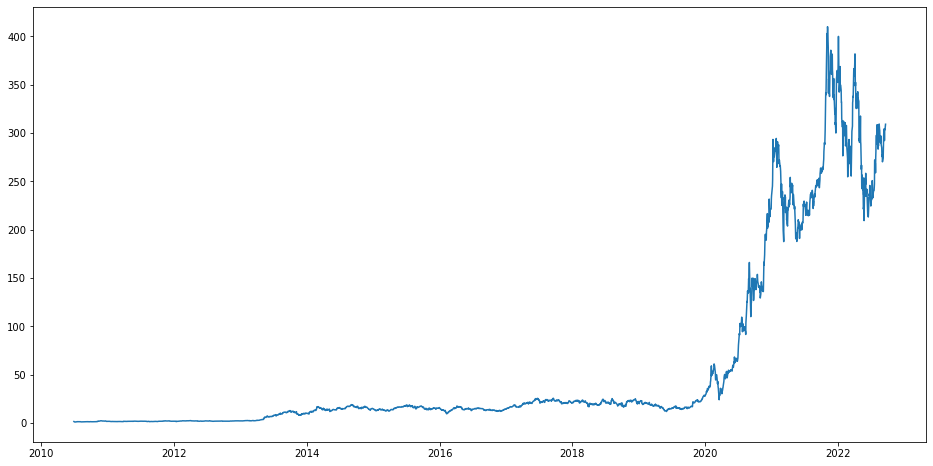

In [11]:
# Görselleştirme

df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close"], label="Close Price History")

### Tarih ve Kapanış fiyatı verilerinin oluşturulması

In [12]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]


### Verilerin ölçeklendirilmesi ve Eğitim-Test verilerinin oluşturulması


In [14]:
scaler=MinMaxScaler(feature_range=(0,1))
final_dataset=new_dataset.values

train_data=final_dataset[0:2600,:]
valid_data=final_dataset[2600:,:]



scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],
                                      x_train_data.shape[1],1))

### Long Short-Term Memory sinir mimarisinin oluşumu ve modelin eğilmesi

In [15]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

2540/2540 - 46s - loss: 2.1650e-04 - 46s/epoch - 18ms/step


### Model kullanılarak tahmin etme ve görseleştirme

15/15 [==============================] - 1s 12ms/step


<ipython-input-16-abdeceed05b9>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


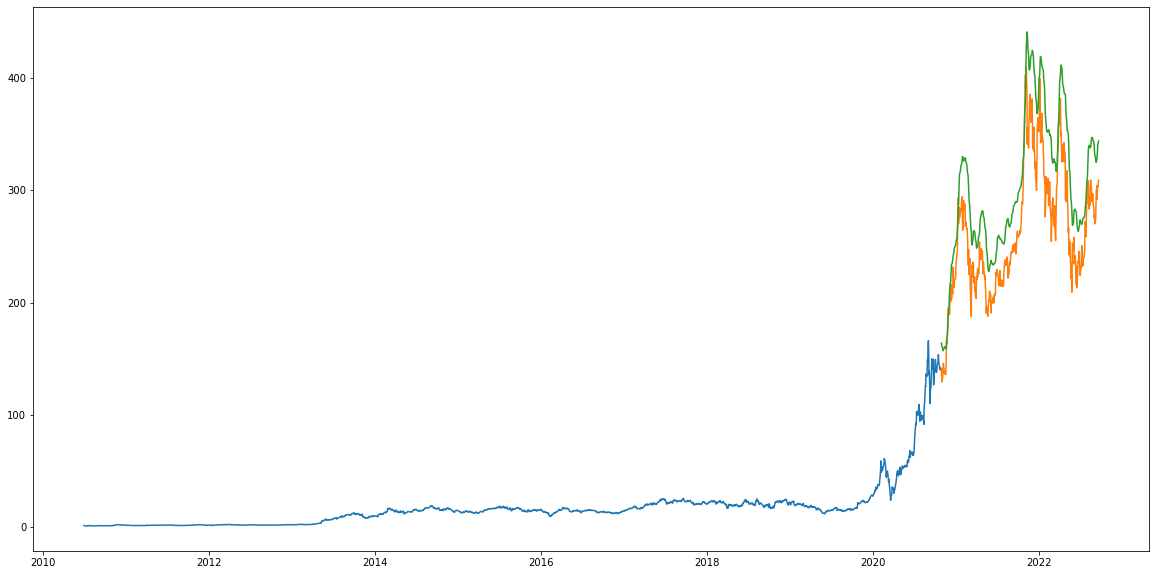

In [16]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

lstm_model.save("saved_model.h5")

train_data=new_dataset[:2600]
valid_data=new_dataset[2600:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])

### Değerlendirme parametreleri

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Mean Absolute Error (MAE)
y_pred = scaler.inverse_transform(predicted_closing_price)
#y_test_unscaled = scaler.inverse_transform(valid_data.reshape(-1, 1))

MAE = mean_absolute_error(valid_data['Close'], valid_data['Predictions'])
print(f'Mean Absolute Error (MAE): {np.round(MAE, 2)}')
# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(valid_data['Close'], valid_data['Predictions'])/
                       valid_data['Close'])))*100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

Mean Absolute Error (MAE): 40.01
Mean Absolute Percentage Error (MAPE): 15.5 %
